<a href="https://colab.research.google.com/github/Swapnil-417/Bike-Sharing-Demand-Prediction/blob/main/Bike_Sharing_Demand_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Seoul Bike Sharing Demand Prediction </u></b>

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# importing the dataset
directory_path = "/content/drive/MyDrive/Capstone Projects/Bike Sharing Demand Prediction – Swapnil Patil/Data/"
bike_df = pd.read_csv(directory_path + "SeoulBikeData.csv", encoding= 'unicode_escape')

# **Getting to Know about Data**

At the very first, we want to start understanding the data.

In [4]:
# first look
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
bike_df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [6]:
bike_df.shape

(8760, 14)

In [7]:
bike_df.columns= map(str.lower, bike_df.columns)
bike_df.columns

Index(['date', 'rented bike count', 'hour', 'temperature(°c)', 'humidity(%)',
       'wind speed (m/s)', 'visibility (10m)', 'dew point temperature(°c)',
       'solar radiation (mj/m2)', 'rainfall(mm)', 'snowfall (cm)', 'seasons',
       'holiday', 'functioning day'],
      dtype='object')

In [8]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented bike count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind speed (m/s)           8760 non-null   float64
 6   visibility (10m)           8760 non-null   int64  
 7   dew point temperature(°c)  8760 non-null   float64
 8   solar radiation (mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall (cm)              8760 non-null   float64
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning day            8760 non-null   objec

In this Dataset, we have 8760 rows and 14 columns from which "rented bike count" is our target variable. There are numerical variables as well as categorical variables and one date variable which is stored as object so we can change its dtype.

In [9]:
# changing dtype of date column
def get_date(date_str):
  date_obj= dt.datetime.strptime(date_str, '%d/%m/%Y')
  date_obj= pd.to_datetime(date_obj.date(), format="%Y-%m-%d")
  return date_obj

bike_df['date'] = bike_df['date'].apply(get_date)

In [ ]:
# adding columns of date, month and year
bike_df['day']= bike_df['date'].dt.day
bike_df['month']= bike_df['date'].dt.month
bike_df['year']= bike_df['date'].dt.year

bike_df= bike_df.drop("date", axis= 1)

In [13]:
bike_df.head()

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,day,month,year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,12,2017


In [14]:
# checking for duplicate values
bike_df.duplicated().sum()

0

In [15]:
# checking for missing values
bike_df.isnull().sum()

rented bike count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind speed (m/s)             0
visibility (10m)             0
dew point temperature(°c)    0
solar radiation (mj/m2)      0
rainfall(mm)                 0
snowfall (cm)                0
seasons                      0
holiday                      0
functioning day              0
day                          0
month                        0
year                         0
dtype: int64

Above we can see there are no missing values as well as no duplicate values in the dataset.

In [16]:
bike_df.describe(include='all')

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day,day,month,year
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760,8760.000000,8760.000000,8760.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465,NaN,NaN,NaN
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN,15.720548,6.526027,2017.915068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN,8.796749,3.448048,0.278796
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,2017.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,4.000000,2018.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN,16.000000,7.000000,2018.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN,23.000000,10.000000,2018.000000


# **Exploratory Data Analysis**

## **Univariate Analysis**

### **Dependent Variable**

First we will start with analyzing our target variable which is **rented bike count**.

In [17]:
dependent_var= "rented bike count"

In [18]:
bike_df[dependent_var].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: rented bike count, dtype: float64

In [19]:
bike_df[dependent_var].value_counts()

0       295
122      19
223      19
262      19
103      18
       ... 
2379      1
1589      1
1597      1
1605      1
2047      1
Name: rented bike count, Length: 2166, dtype: int64

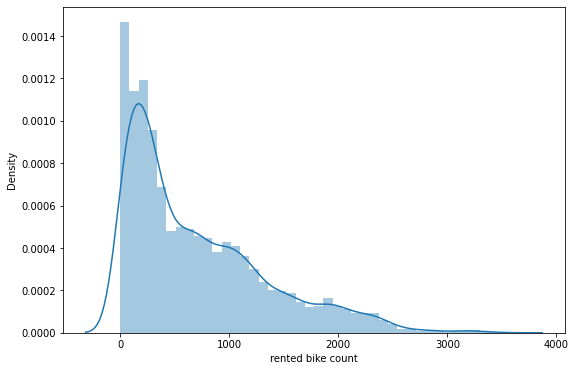

In [20]:
plt.figure(figsize=(9,6))
sns.distplot(bike_df[dependent_var]);

Dependent variable i.e rented bike count is slightly skewed towards right side (positively skewed). So we will apply transformation and again look at the distribution.

Below are some transformation technique to reduce skewness.

<b>square-root for moderate skew:</b>
sqrt(x) for positively skewed data,
sqrt(max(x+1) - x) for negatively skewed data

<b>log for greater skew:</b>
log10(x) for positively skewed data,
log10(max(x+1) - x) for negatively skewed data

<b>inverse for severe skew:</b>
1/x for positively skewed data
1/(max(x+1) - x) for negatively skewed data


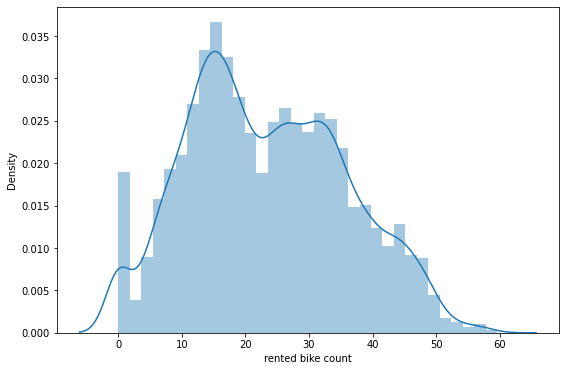

In [21]:
# applying square-root trasnformation
plt.figure(figsize=(9,6))
sns.distplot(np.sqrt(bike_df[dependent_var]));

It looks good and almost near to normal distribution.



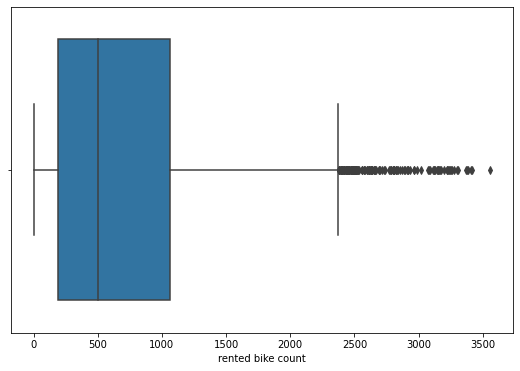

In [22]:
plt.figure(figsize=(9,6))
sns.boxplot(bike_df[dependent_var]);

From boxplot, we can see the median value of rented bike count is near 500 and there are some outliers towards upper limit.

### **Independent Variables**

Starting with the numerical variables.

In [23]:
# numerical variables
num_variables= list(bike_df.describe().columns[1:])

In [24]:
num_variables

['hour',
 'temperature(°c)',
 'humidity(%)',
 'wind speed (m/s)',
 'visibility (10m)',
 'dew point temperature(°c)',
 'solar radiation (mj/m2)',
 'rainfall(mm)',
 'snowfall (cm)',
 'day',
 'month',
 'year']

In [25]:
bike_df[num_variables].describe()

,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),day,month,year
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,15.720548,6.526027,2017.915068
std,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,8.796749,3.448048,0.278796
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,1.000000,1.000000,2017.000000
25%,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,8.000000,4.000000,2018.000000
50%,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,16.000000,7.000000,2018.000000
75%,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,23.000000,10.000000,2018.000000
max,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,31.000000,12.000000,2018.000000


In [26]:
# unique count of numerical variables
lst= []
for col in num_variables:
  lst.append(bike_df[col].nunique())

unique_cnt_df= pd.DataFrame(index= num_variables, columns=['unique_count'])
unique_cnt_df['unique_count']= lst
unique_cnt_df

,unique_count
hour,24
temperature(°c),546
humidity(%),90
wind speed (m/s),65
visibility (10m),1789
dew point temperature(°c),556
solar radiation (mj/m2),345
rainfall(mm),61
snowfall (cm),51
day,31


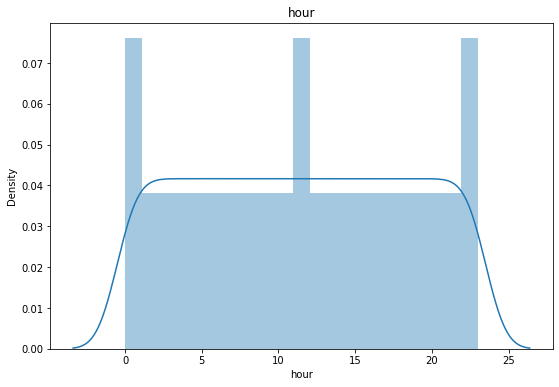

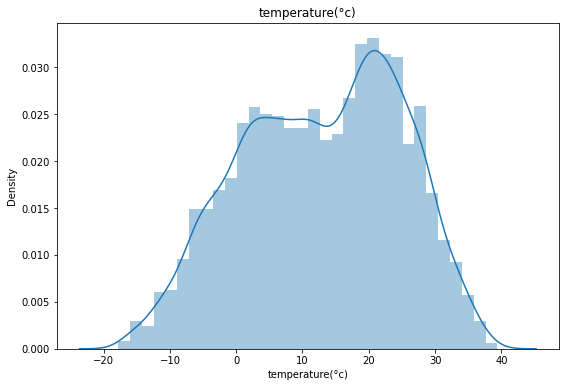

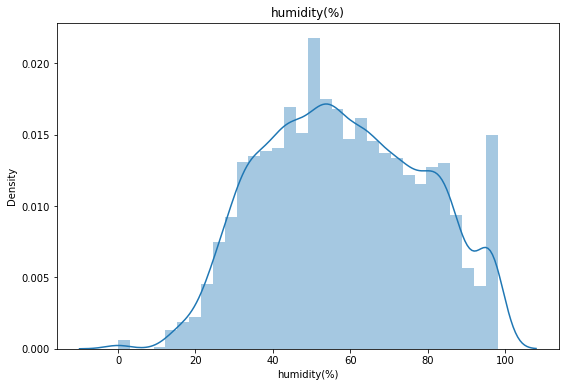

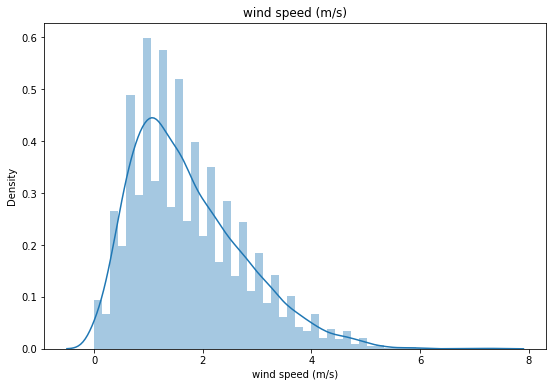

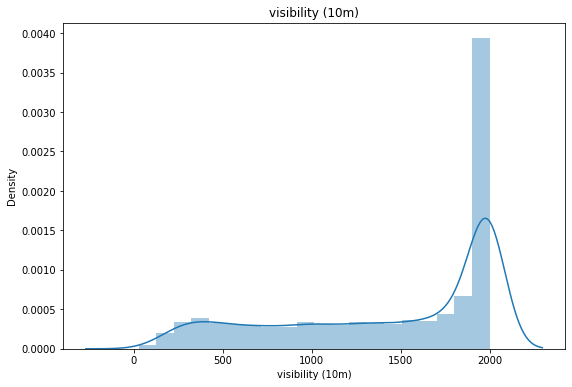

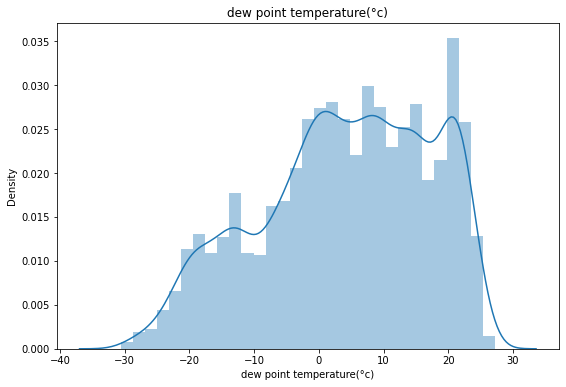

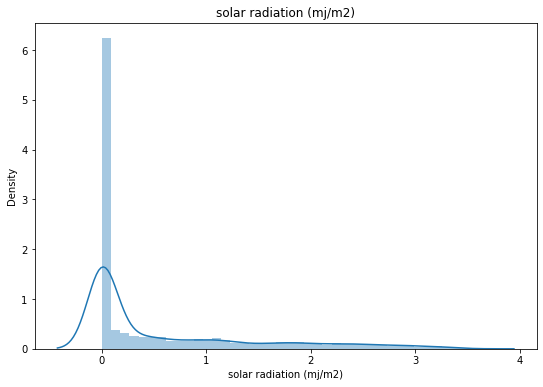

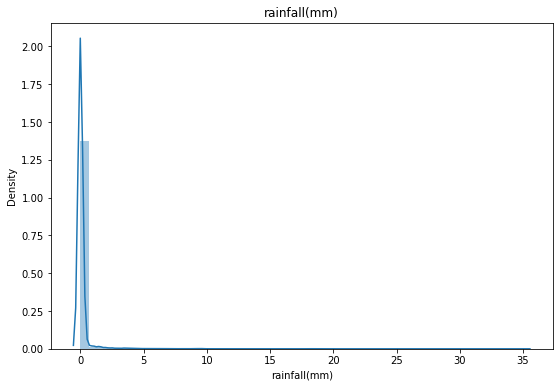

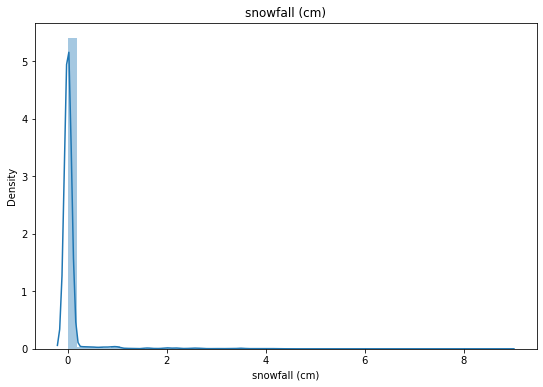

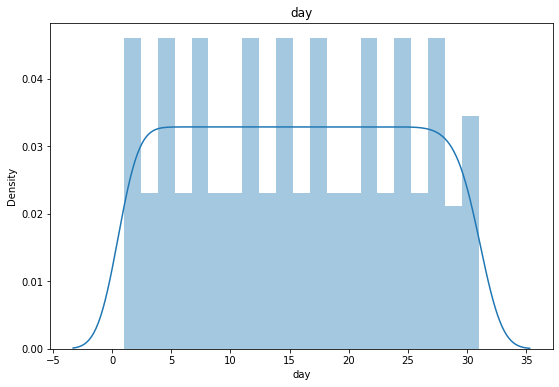

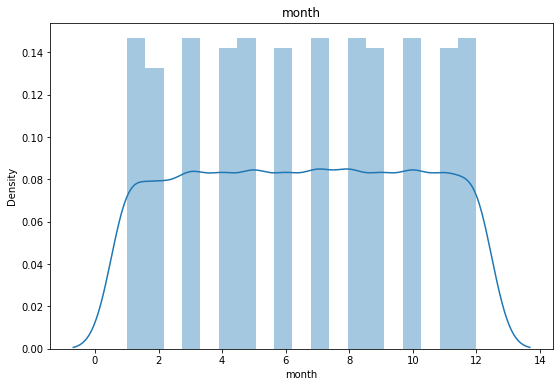

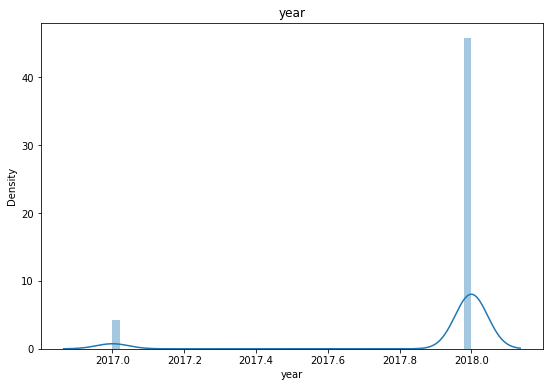

In [27]:
# distribution plot for each numerical feature

for col in num_variables:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  sns.distplot(bike_df[col], ax= ax)
  ax.set_title(col)
plt.show()

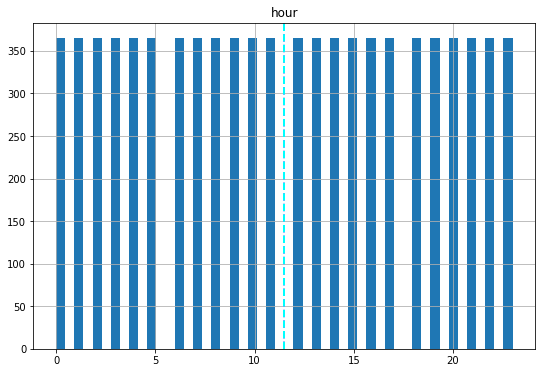

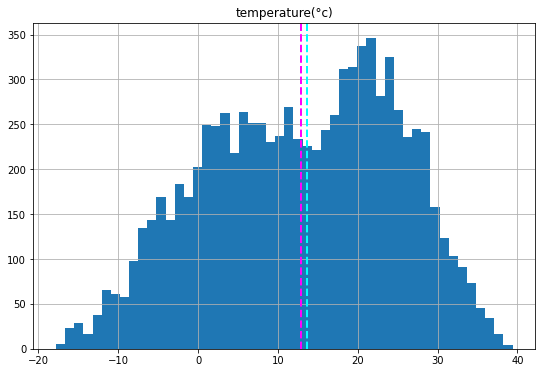

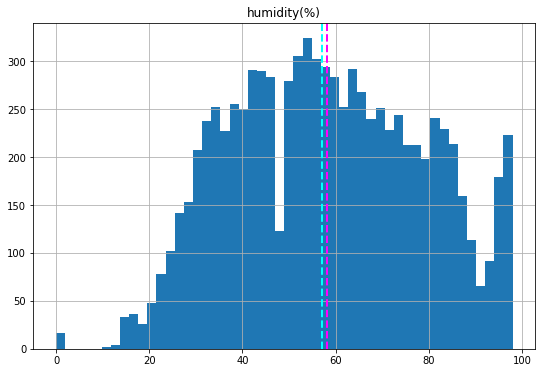

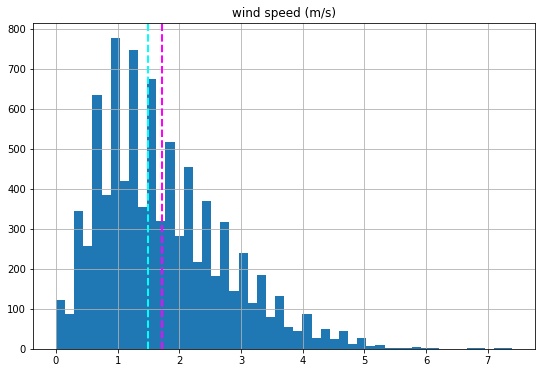

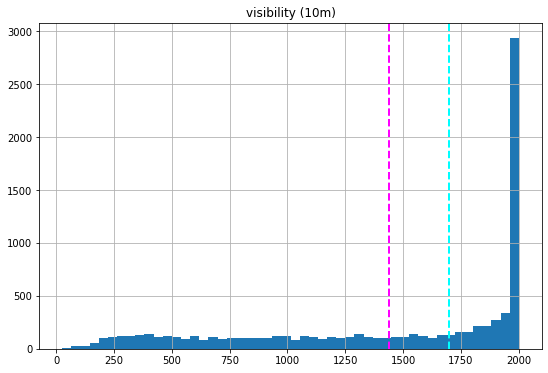

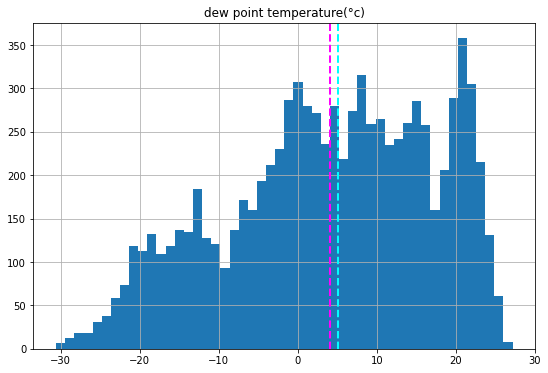

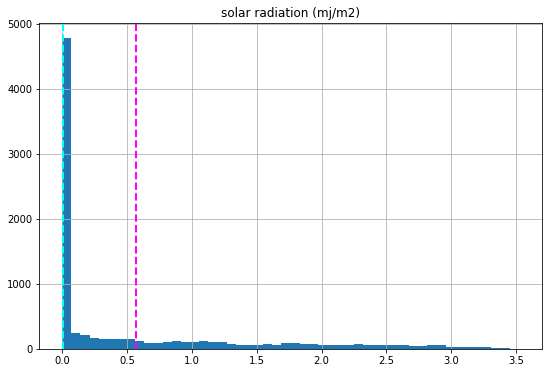

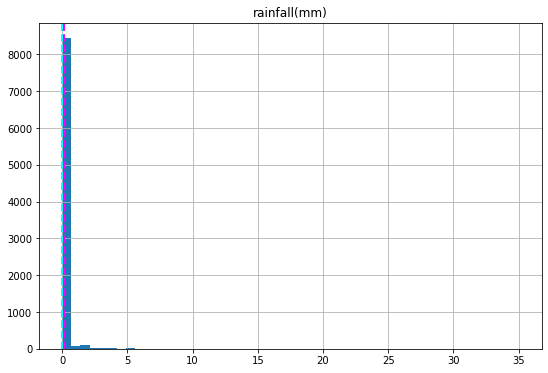

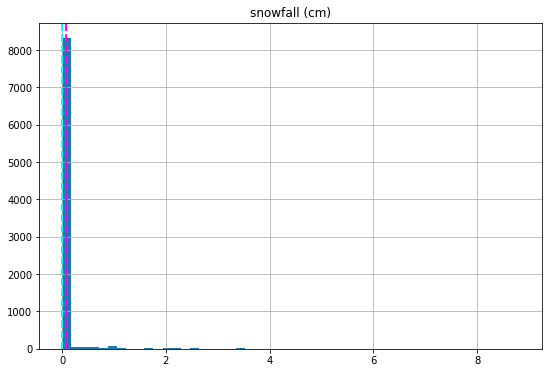

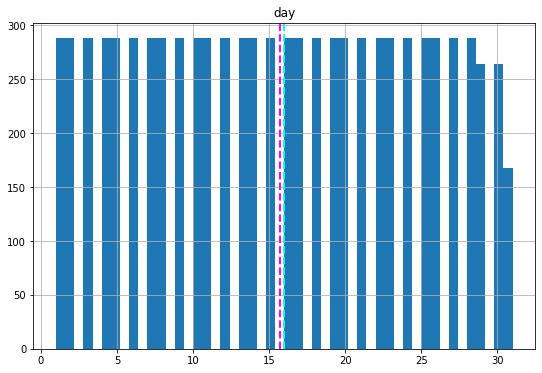

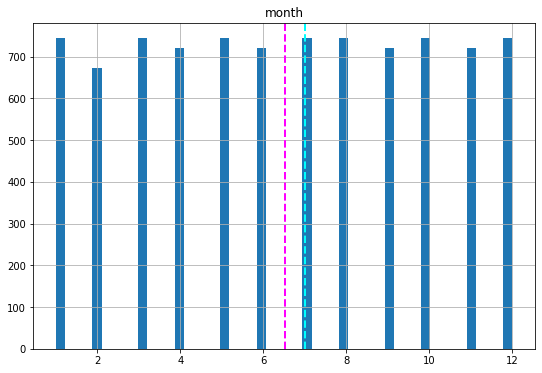

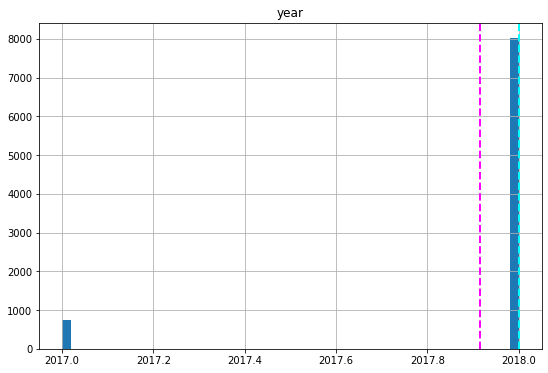

In [28]:
# histogram for each numerical feature count

for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

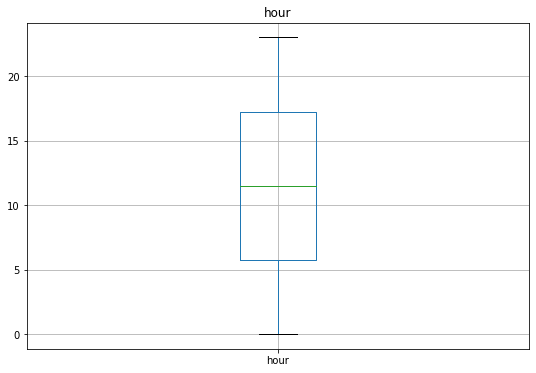

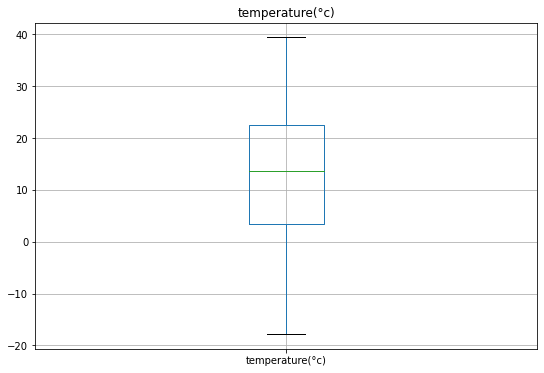

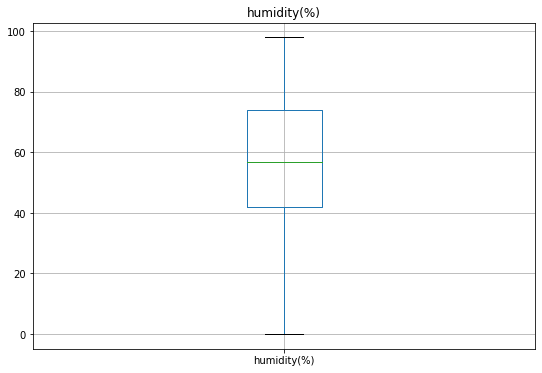

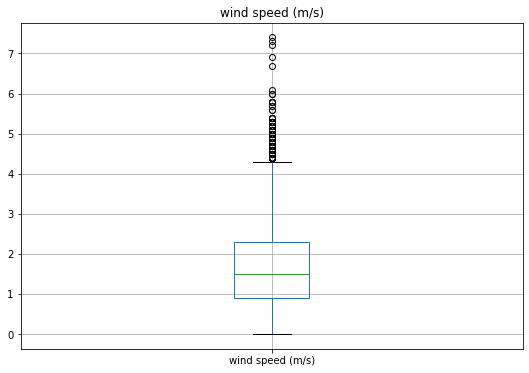

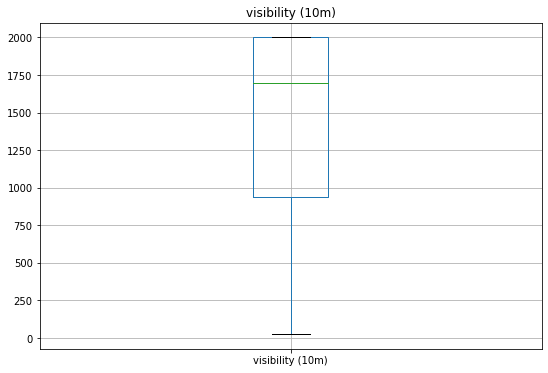

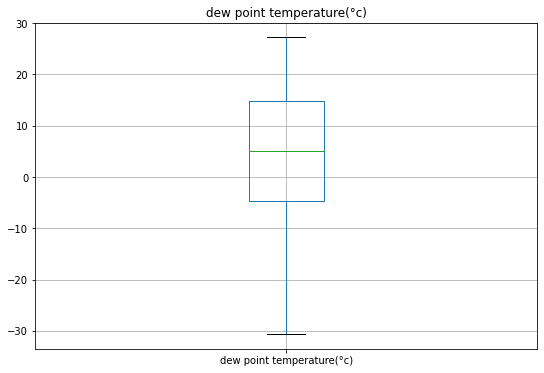

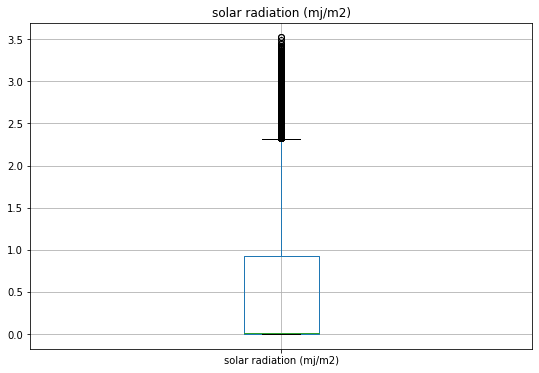

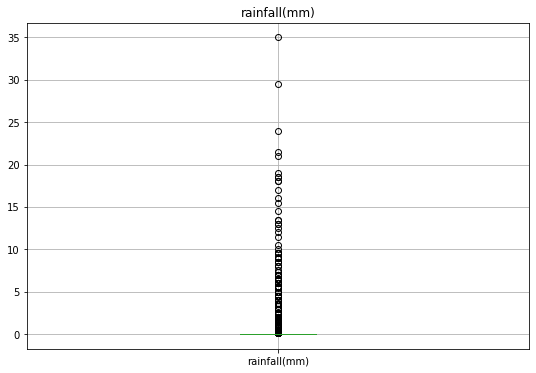

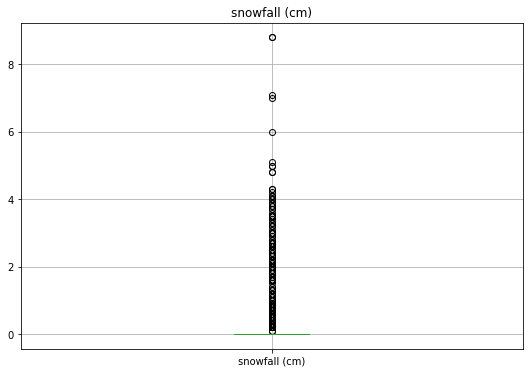

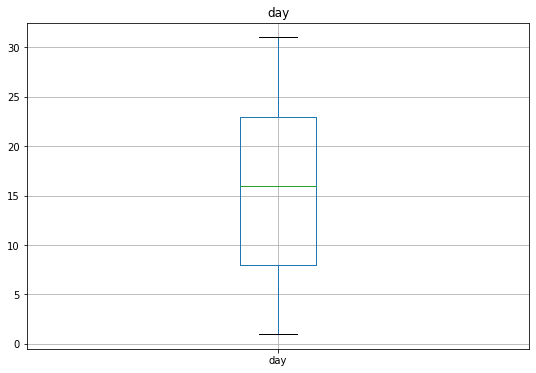

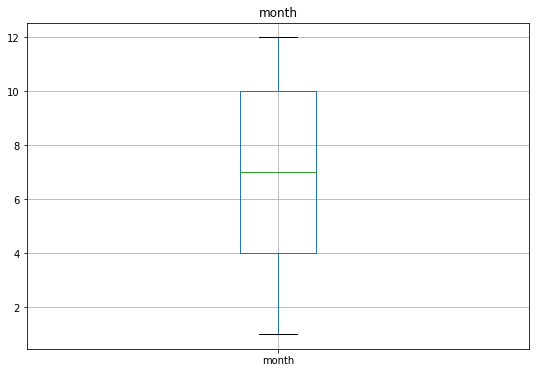

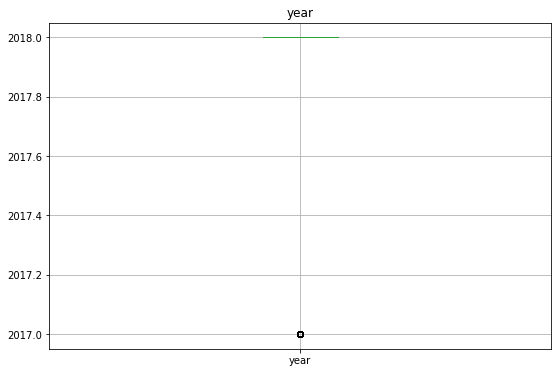

In [29]:
# boxplot for each numerical feature  

for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_df.boxplot(col, ax= ax)
    ax.set_title(col)
plt.show()

Variables such as wind speed (m/s), solar radiation (mj/m2), rainfall(mm), snowfall (cm) has outliers as seen in the boxplot.

### **Categorical Variables**

In [30]:
cat_variables= ['seasons', 'holiday', 'functioning day']

Look at the different values of distinct categories in our variables.

In [31]:
# Seasons column
print(f"Count of distinct categories in season variable: {bike_df['seasons'].nunique()}")
bike_df["seasons"].unique()

Count of distinct categories in season variable: 4


array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [32]:
# holiday column
print(f"Count of distinct categories in holiday variable: {bike_df['holiday'].nunique()}")
bike_df["holiday"].unique()

Count of distinct categories in holiday variable: 2


array(['No Holiday', 'Holiday'], dtype=object)

In [33]:
# functioning day column
print(f"Count of distinct categories in functioning day variable: {bike_df['functioning day'].nunique()}")
bike_df["functioning day"].unique()

Count of distinct categories in functioning day variable: 2


array(['Yes', 'No'], dtype=object)

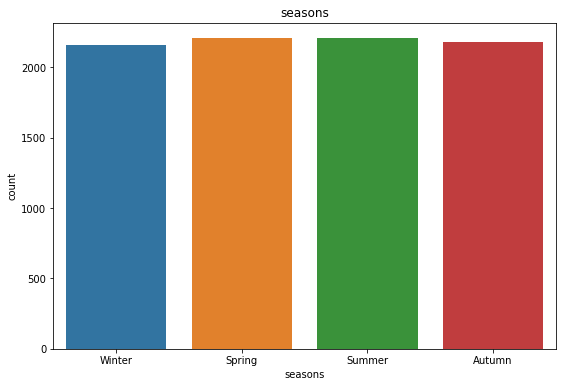

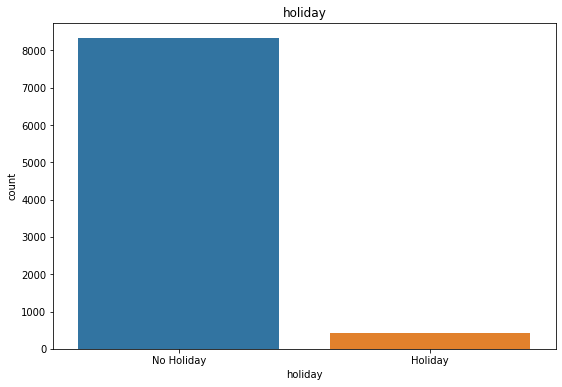

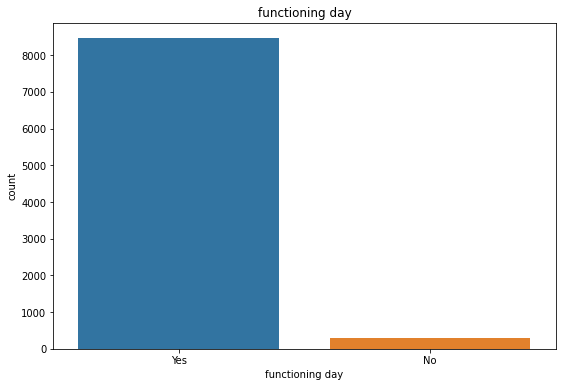

In [34]:
# count plot
for col in cat_variables:
  plt.figure(figsize=(9,6))
  sns.countplot(data = bike_df, x = col)
  plt.title(col);

## **Bivariate Analysis**


### Numerical variables v/s rented bike count

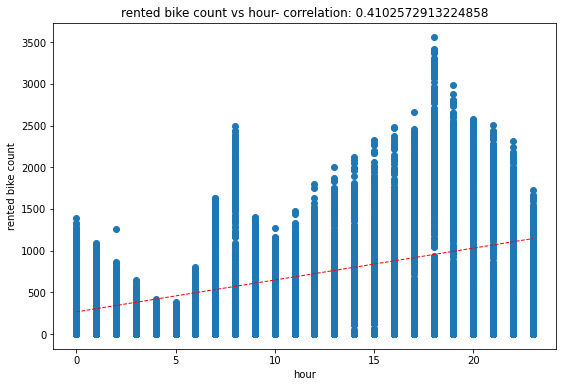

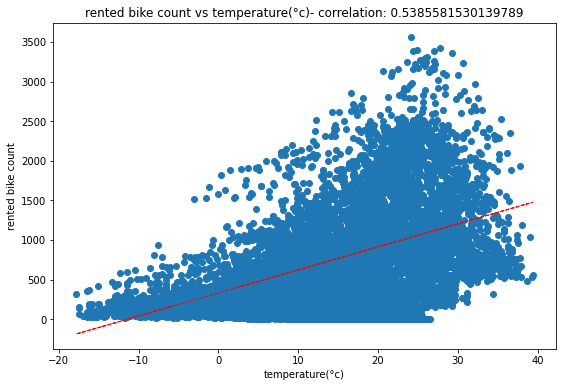

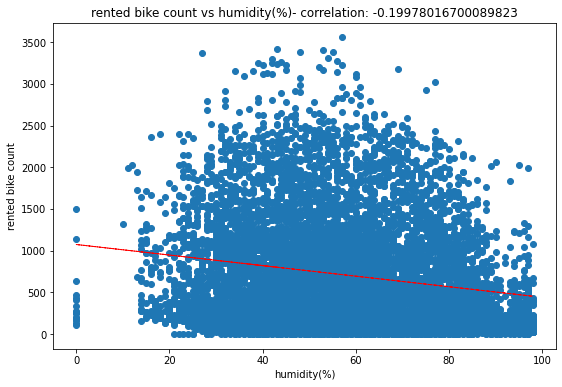

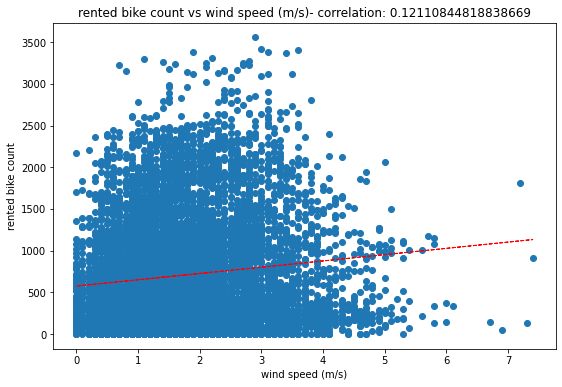

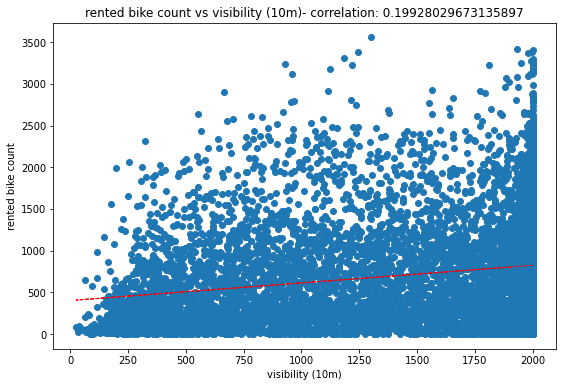

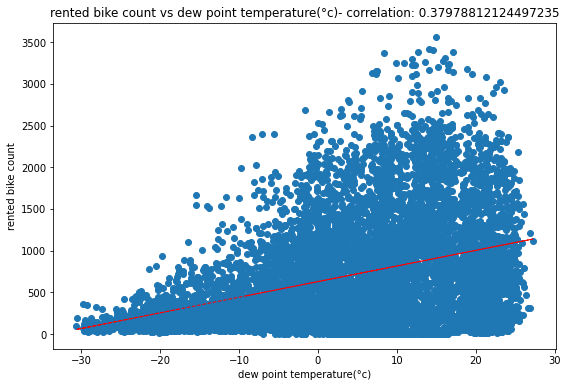

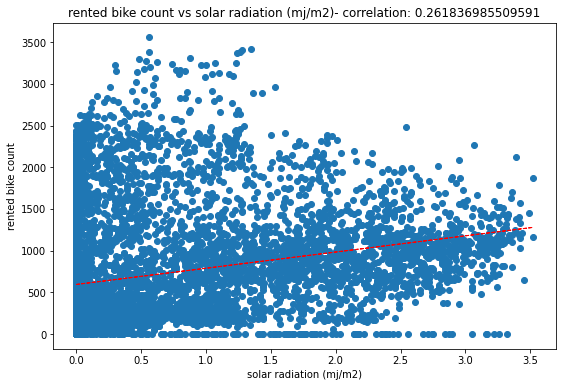

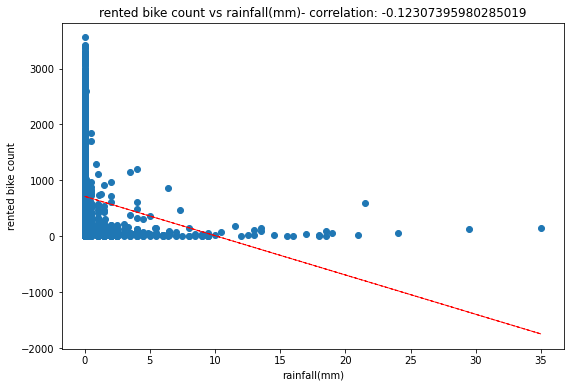

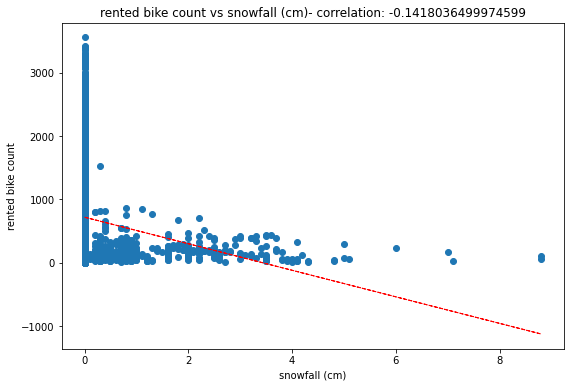

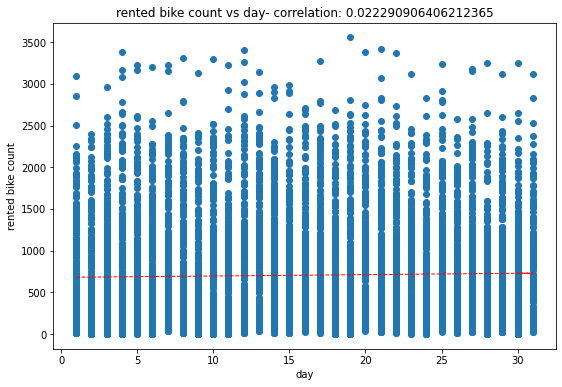

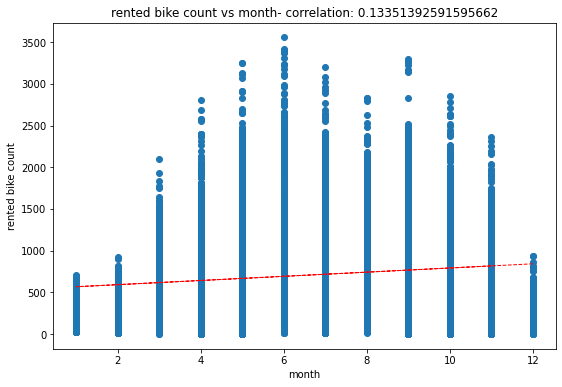

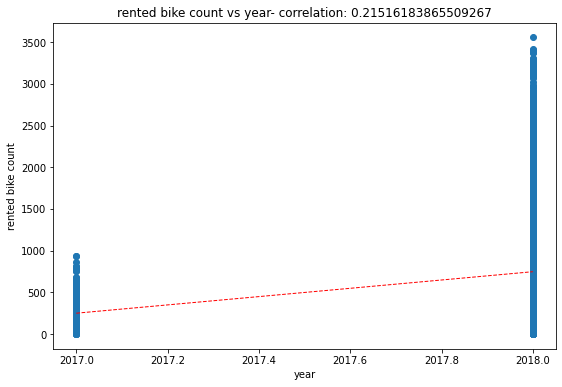

In [35]:
# scatterplot numerical_var v/s rented bike count
for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_df[col]
    label = bike_df['rented bike count']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('rented bike count')
    ax.set_title('rented bike count vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(bike_df[col], bike_df['rented bike count'], 1)
    y_hat = np.poly1d(z)(bike_df[col])

    plt.plot(bike_df[col], y_hat, "r--", lw=1)

plt.show()

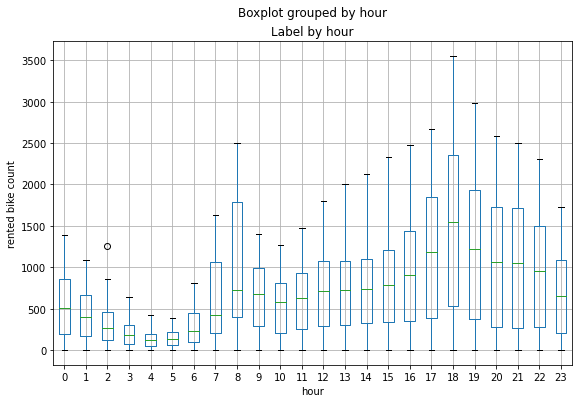

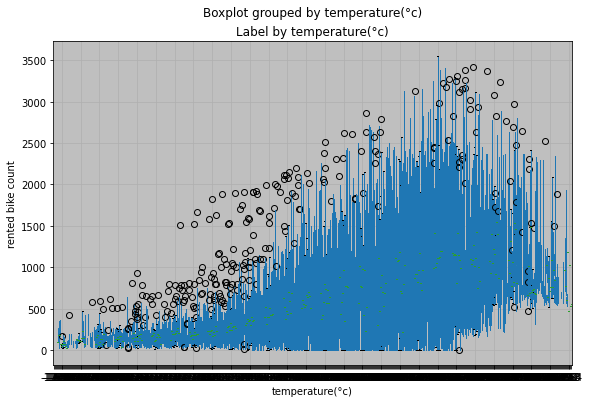

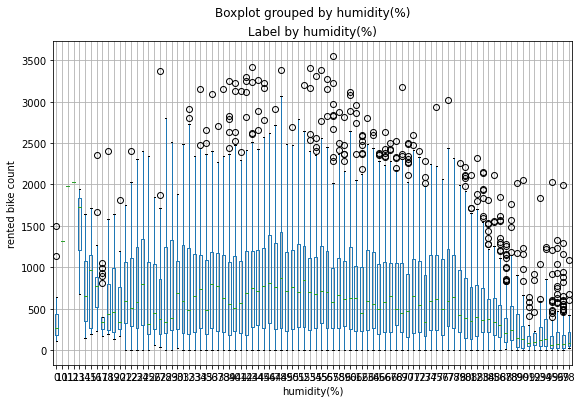

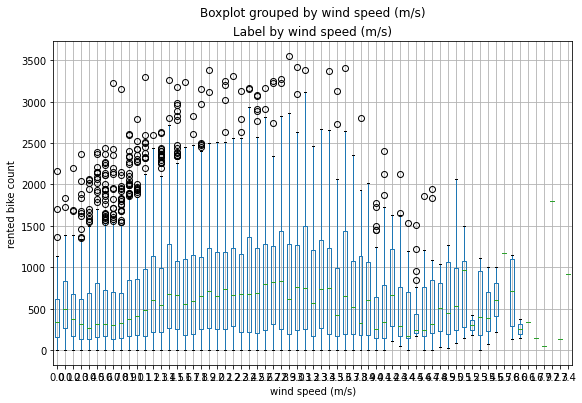

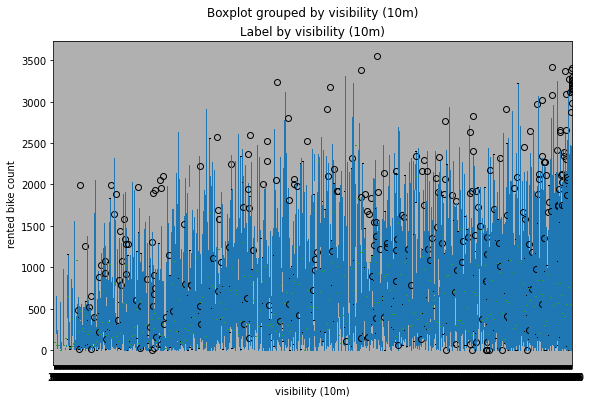

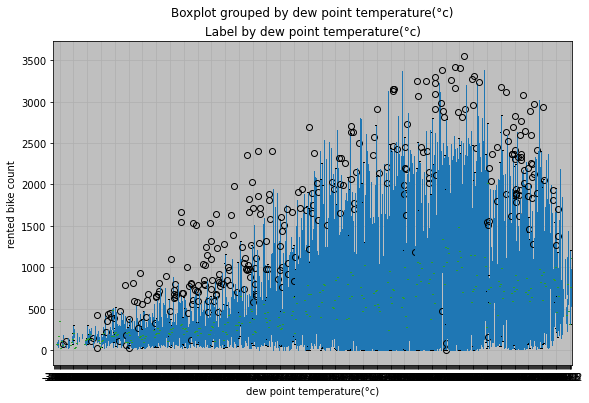

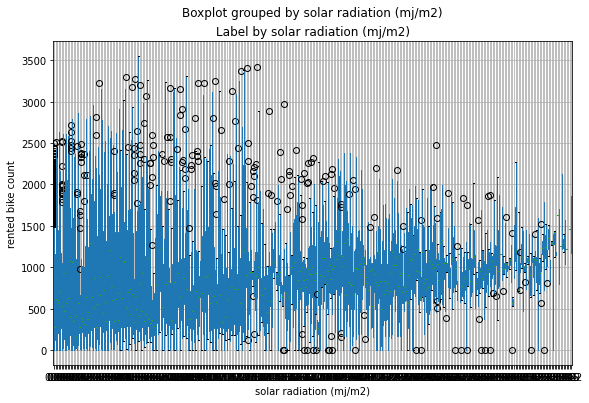

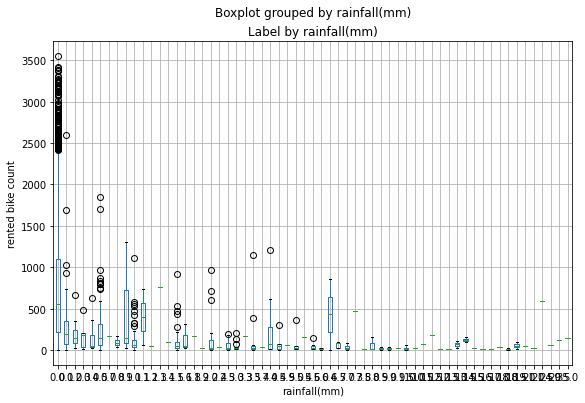

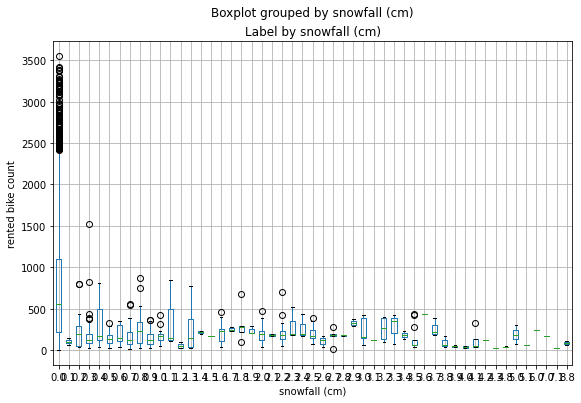

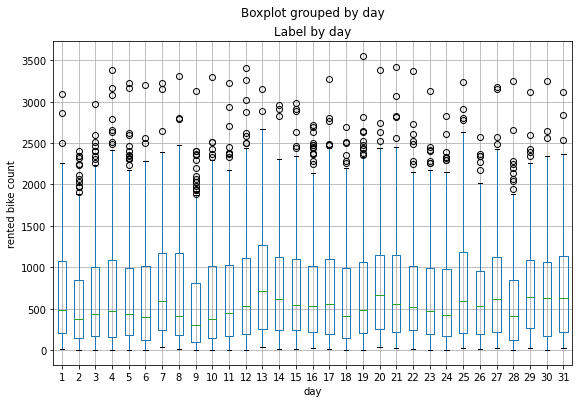

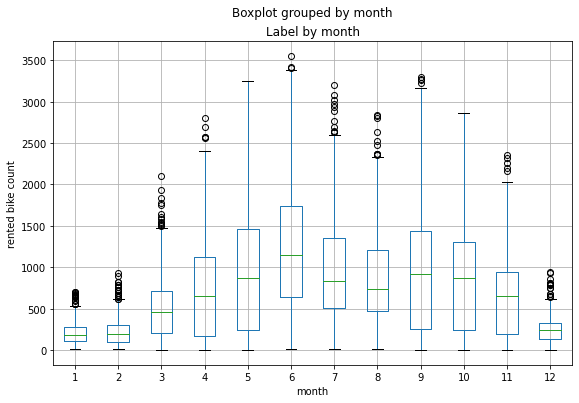

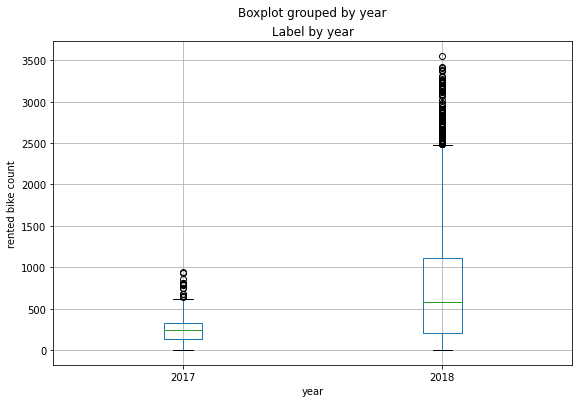

In [36]:
# boxplot numerical_var v/s rented bike count
for col in num_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_df.boxplot(column = 'rented bike count', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("rented bike count")
plt.show()

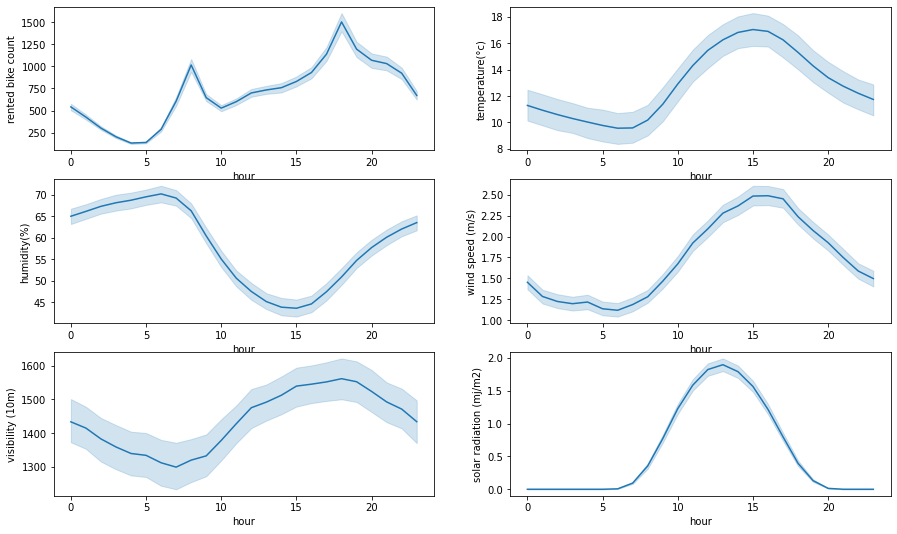

In [37]:
# Analysis of numerical variables during hours
fig, ax = plt.subplots(3,2,figsize=(15,9))

sns.lineplot('hour', 'rented bike count', data=bike_df, ax=ax[0][0])

sns.lineplot('hour', 'temperature(°c)', data=bike_df, ax=ax[0][1])

sns.lineplot('hour', 'humidity(%)', data=bike_df, ax=ax[1][0])

sns.lineplot('hour', 'wind speed (m/s)', data=bike_df, ax=ax[1][1])

sns.lineplot('hour', 'visibility (10m)', data=bike_df, ax=ax[2][0])

sns.lineplot('hour', 'solar radiation (mj/m2)', data=bike_df, ax=ax[2][1])

plt.show()

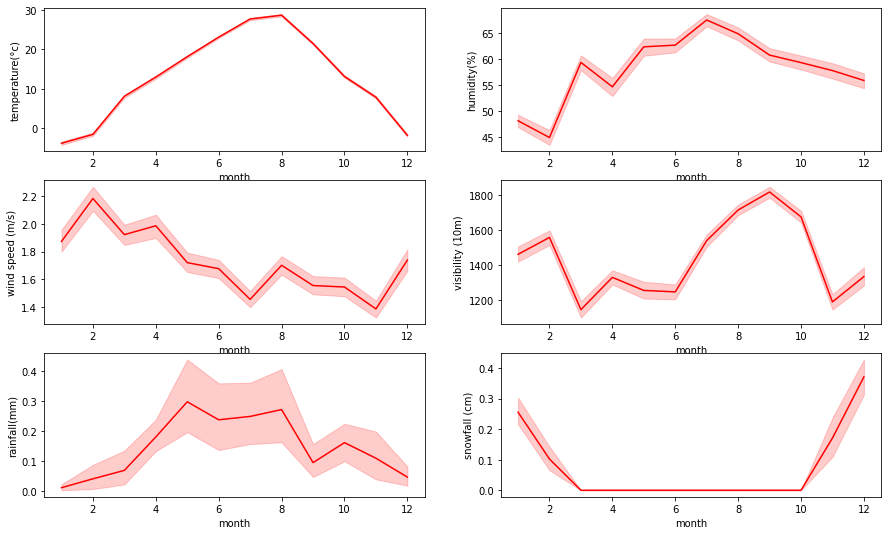

In [38]:
# Analysis of numerical variables across months
fig, ax = plt.subplots(3,2,figsize=(15,9))

sns.lineplot('month', 'temperature(°c)', data=bike_df, color='r', ax=ax[0][0])

sns.lineplot('month', 'humidity(%)', data=bike_df, color='r', ax=ax[0][1])

sns.lineplot('month', 'wind speed (m/s)', data=bike_df, color='r', ax=ax[1][0])

sns.lineplot('month', 'visibility (10m)', data=bike_df, color='r', ax=ax[1][1])

sns.lineplot('month', 'rainfall(mm)', data=bike_df, color='r', ax=ax[2][0])

sns.lineplot('month', 'snowfall (cm)', data=bike_df, color='r', ax=ax[2][1])

plt.show()

### Categorical Variables v/s rented bike count

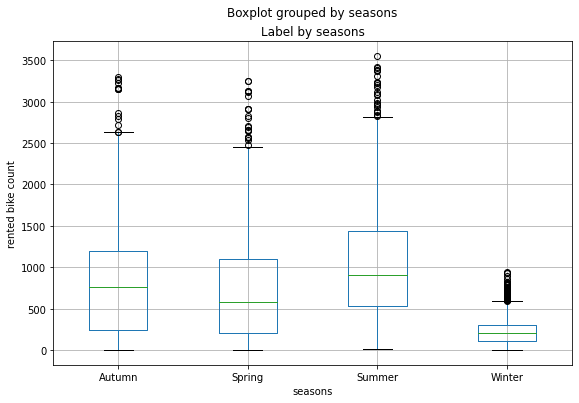

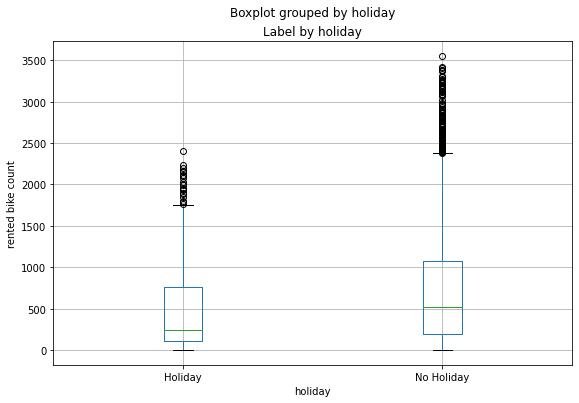

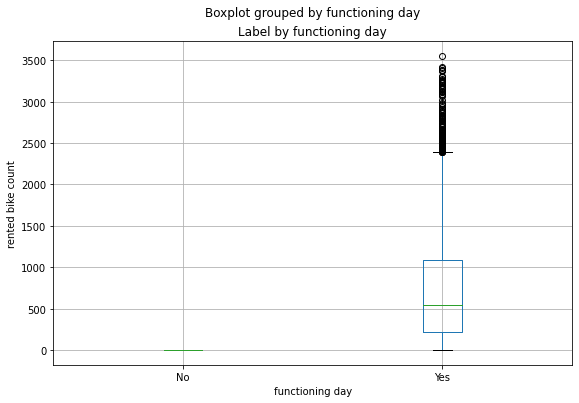

In [39]:
# boxplot categorical_var v/s rented bike count
for col in cat_variables:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_df.boxplot(column = 'rented bike count', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("rented bike count")
plt.show()

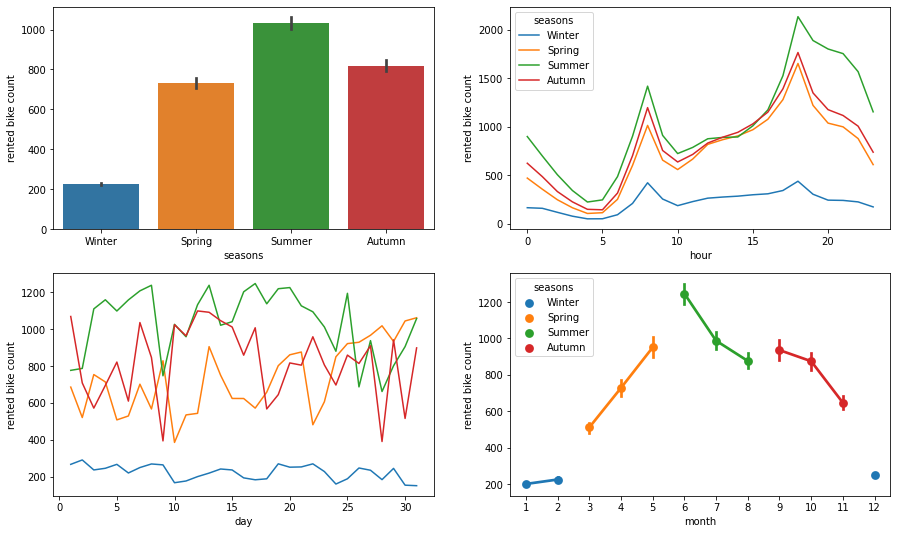

In [40]:
# Analysis of rented bike count on hour, day and monthly basis
fig, ax = plt.subplots(2,2,figsize=(15,9))

sns.barplot(x= 'seasons', y= dependent_var, data= bike_df, ax= ax[0][0])

sns.lineplot(x= 'hour', y= dependent_var, hue= 'seasons',
             ci=None, data= bike_df, ax= ax[0][1])

sns.lineplot(x= 'day', y= dependent_var, hue= 'seasons',
             ci=None, data= bike_df, legend=False, ax= ax[1][0])

sns.pointplot(x= 'month', y= dependent_var, hue= 'seasons',
              data= bike_df, ax= ax[1][1])

plt.show()

The highest number of bike rents occur in summer while the least bike rents occur in winter. On hourly basis, mostly bike rents occur in morning at 8:00 and in evening at 17:00. The bike count rises in afternoon. According to months, highest number of bike rents occur in June and least in January.

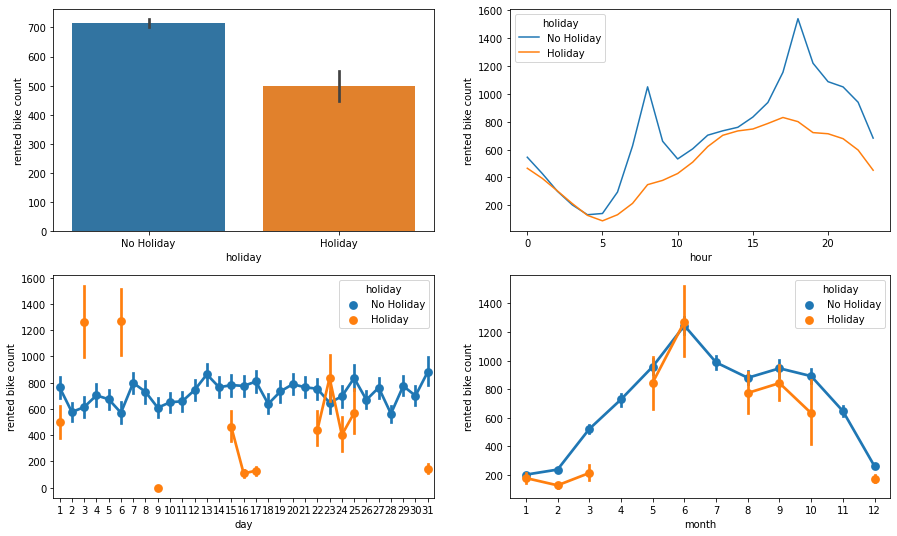

In [41]:
# Analysis of rented bike count on hour, day and monthly basis during holidays
fig, ax = plt.subplots(2,2,figsize=(15,9))

sns.barplot(x= 'holiday', y= dependent_var, data= bike_df, ax= ax[0][0])

sns.lineplot(x= 'hour', y= dependent_var, hue= 'holiday',
             ci=None, data= bike_df, ax= ax[0][1])

sns.pointplot(x= 'day', y= dependent_var, hue= 'holiday',
             data= bike_df, ax= ax[1][0])

sns.pointplot(x= 'month', y= dependent_var, hue= 'holiday',
              data= bike_df, ax= ax[1][1])

plt.show()

# **Feature Selection**

### **Correlation**

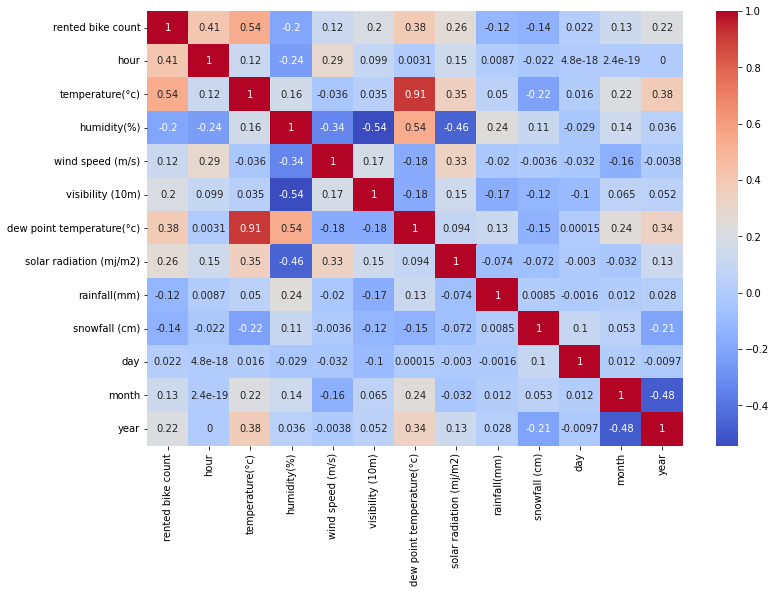

In [42]:
corr_df= bike_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True, cmap= 'coolwarm');

### **Detecting Multicollinearity using VIF**

In [43]:
#Multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [44]:
calc_vif(bike_df[[i for i in num_variables]])

,variables,VIF
0,hour,4.458880
1,temperature(°c),188.666573
2,humidity(%),187.533688
3,wind speed (m/s),4.890096
4,visibility (10m),10.788995
5,dew point temperature(°c),126.954261
6,solar radiation (mj/m2),2.904971
7,rainfall(mm),1.103386
8,snowfall (cm),1.155412
9,day,4.379818


We can see here that the 'year', 'dew point temperature(°c)', 'temperature(°c)', and 'humidity(%)'  have a high VIF value, meaning they can be predicted by other independent variables in the dataset.

Dropping one of the correlated features will help in bringing down the multicollinearity between correlated features.

In [45]:
# droping 'dew point temperature(°c)', 'year', 'day', 'month'
calc_vif(bike_df[[i for i in num_variables if i not in ['dew point temperature(°c)', 'year', 'day', 'month']]])

,variables,VIF
0,hour,3.921832
1,temperature(°c),3.228318
2,humidity(%),4.868221
3,wind speed (m/s),4.608625
4,visibility (10m),4.710170
5,solar radiation (mj/m2),2.246791
6,rainfall(mm),1.079158
7,snowfall (cm),1.120579


After droping 'dew point temperature(°c)', 'year', 'day' and 'month', VIF values for all features have decreased less than 5 that is good to build regression model.

In [46]:
# droping 'dew point temperature(°c)', 'year', 'day', 'month' from original dataset
dataset= bike_df.drop(['dew point temperature(°c)', 'year', 'day', 'month'], axis=1)

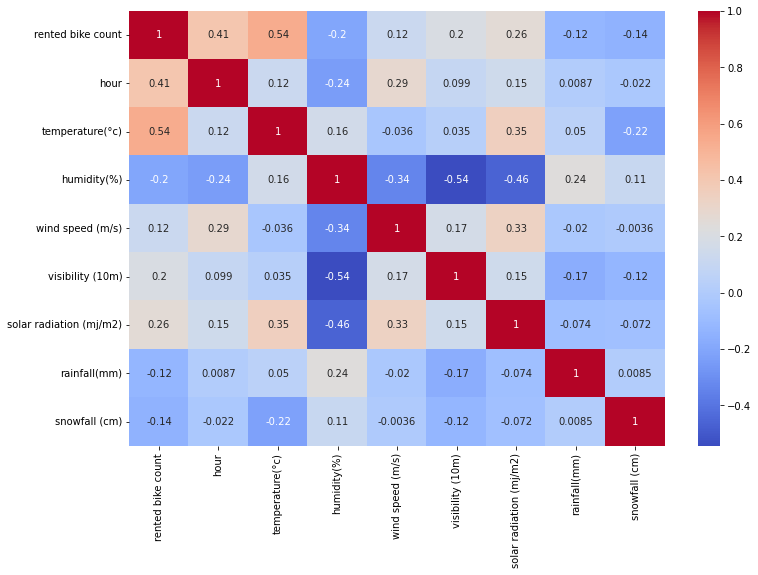

In [47]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(), annot=True, cmap= 'coolwarm');

## **Feature Engineering**




In [48]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_en = LabelEncoder()
dataset[cat_variables] = dataset[cat_variables].apply(label_en.fit_transform)

In [49]:
dataset.head()

,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,1
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,1
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,1
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,1
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,1


### **Data Preparation**

In [50]:
X= dataset.drop(dependent_var, axis=1)
y= np.sqrt(dataset[dependent_var])

In [51]:
X.head()

,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day
0,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,1
1,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,1
2,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,1
3,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,1
4,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,1


In [52]:
y.head()

0    15.937377
1    14.282857
2    13.152946
3    10.344080
4     8.831761
Name: rented bike count, dtype: float64

In [53]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # transform data
# X = scaler.fit_transform(X)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [55]:
X_train.shape

(6132, 11)

In [56]:
X_test.shape

(2628, 11)

# **Linear Regression**

In [57]:
# fitting Linear Regression model

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [58]:
# model score
lin_reg.score(X_train, y_train)

0.651355683589824

In [59]:
lin_reg.coef_

array([ 4.78652264e-01,  5.56240481e-01, -1.56138914e-01,  5.93000262e-02,
        4.59576719e-04, -9.93647039e-01, -1.52301728e+00,  1.81809489e-01,
       -2.13294439e+00,  3.33973901e+00,  2.86968277e+01])

In [60]:
lin_reg.intercept_

-7.766377735246877

In [61]:
# predictions on train and test data
train_pred_lr= lin_reg.predict(X_train)
test_pred_lr= lin_reg.predict(X_test)

### **Evaluation Metrics**

In [62]:
def evaluation_metrics(train_pred, test_pred):

  ''' takes train_predictions and test_predictions as input
      and gives evaluation metrics as output for both train and test data '''

  # Evaluation metrics for train data
  print("Evaluation metrics for train data")
  MSE  = mean_squared_error(y_train, train_pred)
  print("MSE :" , MSE)
  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)
  MAE= mean_absolute_error(y_train, train_pred)
  print("MAE :",MAE)
  print(" ")
  r2 = r2_score(y_train, train_pred)
  print("R2 :" ,r2)
  print("Adjusted R2 : ",1-(1-r2_score(y_train, train_pred))*
        ((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

  print('-'*50)

  # Evaluation metrics for test data
  print("Evaluation metrics for test data")
  MSE  = mean_squared_error(y_test, test_pred)
  print("MSE :" , MSE)
  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)
  MAE= mean_absolute_error(y_test, test_pred)
  print("MAE :",MAE)
  print(" ")
  r2 = r2_score(y_test, test_pred)
  print("R2 :" ,r2)
  print("Adjusted R2 : ",1-(1-r2_score(y_test, test_pred))*
        ((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [63]:
evaluation_metrics(train_pred_lr, test_pred_lr)

Evaluation metrics for train data
MSE : 54.23249788666868
RMSE : 7.36427171461433
MAE : 5.634530901082256
 
R2 : 0.651355683589824
Adjusted R2 :  0.6498896715559891
--------------------------------------------------
Evaluation metrics for test data
MSE : 54.354342221307505
RMSE : 7.372539740232501
MAE : 5.674272451729157
 
R2 : 0.6461261744896516
Adjusted R2 :  0.6446381729297839


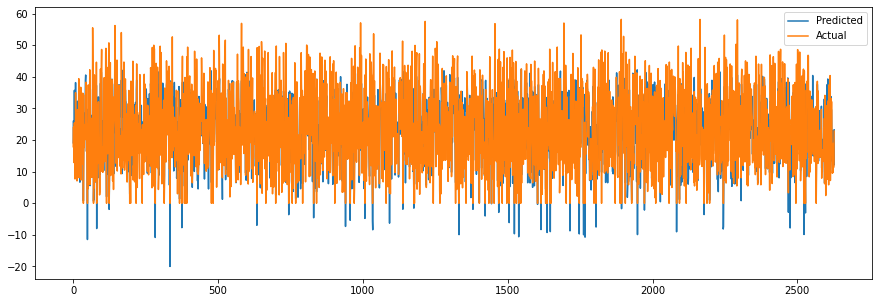

In [64]:
plt.figure(figsize=(15,5))
plt.plot(np.array(test_pred_lr))
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

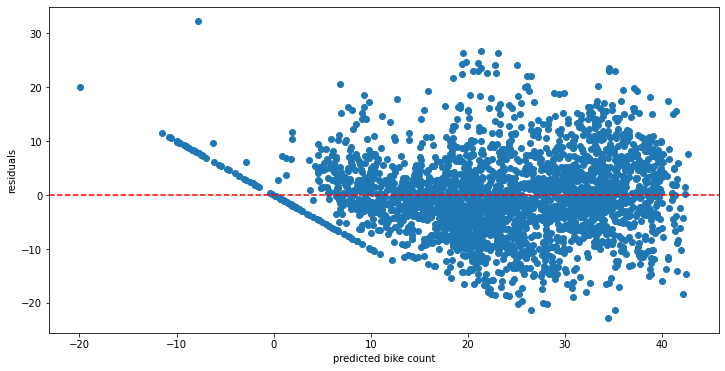

In [65]:
# Heteroscadacity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_lr, y_test- test_pred_lr)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

# **Random Forest Regressor**

In [67]:
# create regressor object
rf_reg= RandomForestRegressor(n_estimators = 100, random_state = 0)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [68]:
# making predictions on train and test data
train_pred_rf= rf_reg.predict(X_train)
test_pred_rf= rf_reg.predict(X_test)

### **Evaluation Metrics**

In [69]:
evaluation_metrics(train_pred_rf, test_pred_rf)

Evaluation metrics for train data
MSE : 2.2229245391122987
RMSE : 1.4909475306369098
MAE : 1.0001613307722377
 
R2 : 0.9857094908667166
Adjusted R2 :  0.9856494008053763
--------------------------------------------------
Evaluation metrics for test data
MSE : 16.158479083190002
RMSE : 4.019761072898488
MAE : 2.732437411313327
 
R2 : 0.8948002574602798
Adjusted R2 :  0.8943579038028115


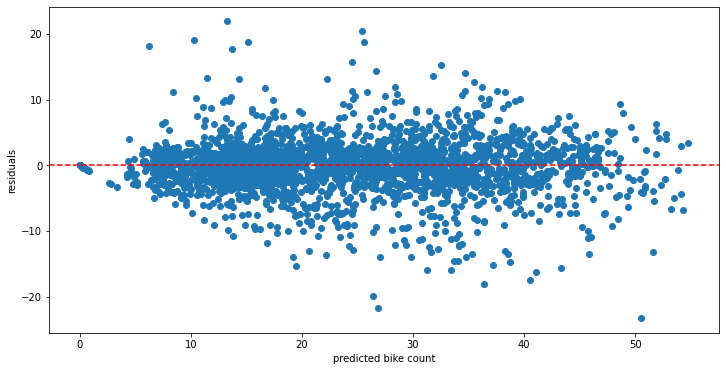

In [70]:
# Heteroscadacity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_rf, y_test- test_pred_rf)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

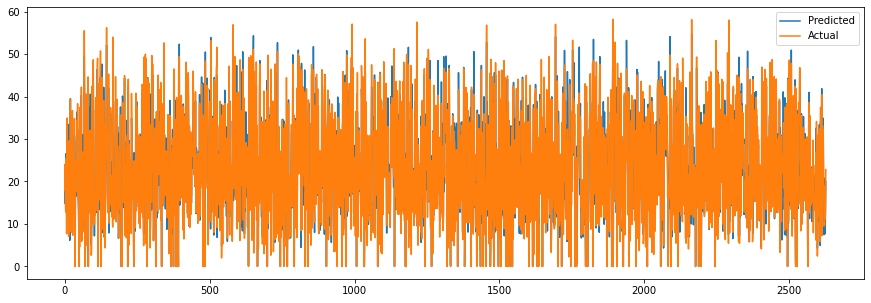

In [71]:
plt.figure(figsize=(15,5))
plt.plot(np.array(test_pred_rf))
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importance**

In [72]:
# Get numerical feature importances
importances = list(rf_reg.feature_importances_)

# Dictionary with variable and importance
feature_importances= {'feature':list(X.columns), 'feature_importance':importances}

importance_df= pd.DataFrame(feature_importances)
importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)
importance_df

,feature,feature_importance
1,temperature(°c),0.287310
0,hour,0.239025
10,functioning day,0.154977
2,humidity(%),0.123399
8,seasons,0.059371
6,rainfall(mm),0.055317
5,solar radiation (mj/m2),0.041543
4,visibility (10m),0.018485
3,wind speed (m/s),0.016392
9,holiday,0.002755


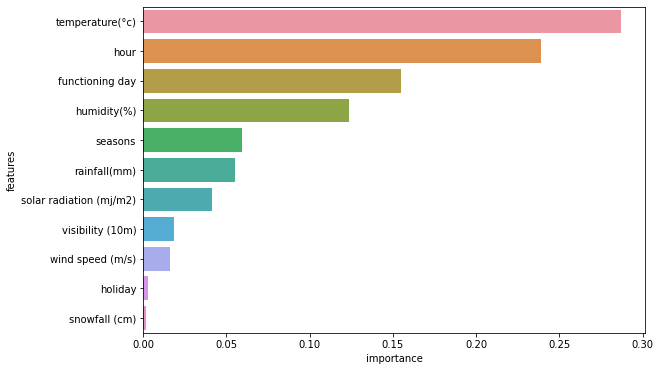

In [74]:
# plot feature importance
plt.figure(figsize=(9,6))

sns.barplot(x='feature_importance', y='feature', data=importance_df)

# setting labels
plt.xlabel("importance")
plt.ylabel("features")

plt.show()

# **Random Forest with GridSearchCV**

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
# hyperparameter grid
param_dict_rf = {
    'n_estimators': [50, 80, 100],
    'max_depth': [4, 6, 8],
    'min_samples_split': [50, 100, 150],
    'min_samples_leaf': [40, 50]
  }

In [77]:
# create regressor object
rf_model= RandomForestRegressor(random_state= 0)

# fitting gridsearch
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict_rf,
                       cv = 5, verbose=2)

rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.4s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.3s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.5s
[CV] END max_depth=4, min_sam

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             verbose=2)

In [78]:
# best parameters
rf_grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 40,
 'min_samples_split': 50,
 'n_estimators': 80}

In [79]:
# optimal model
rf_optimal_model= rf_grid.best_estimator_

In [80]:
# Model score
rf_optimal_model.score(X_train,y_train)

0.8564122976744989

In [81]:
# Making predictions on train and test data
train_pred_rf_grid= rf_optimal_model.predict(X_train)
test_pred_rf_grid= rf_optimal_model.predict(X_test)

### **Evaluation Metrics**

In [82]:
evaluation_metrics(train_pred_rf_grid,test_pred_rf_grid)

Evaluation metrics for train data
MSE : 22.33542724315602
RMSE : 4.726037160577138
MAE : 3.4082350487544777
 
R2 : 0.8564122976744989
Adjusted R2 :  0.8558085267549345
--------------------------------------------------
Evaluation metrics for test data
MSE : 25.797455511796898
RMSE : 5.079119560691291
MAE : 3.6602072265862535
 
R2 : 0.8320457226172833
Adjusted R2 :  0.8313394928576464


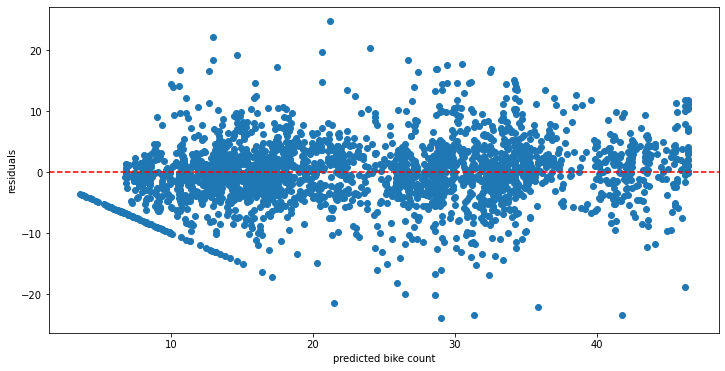

In [84]:
# Heteroscadacity
plt.figure(figsize=(12,6))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_rf_grid, y_test- test_pred_rf_grid)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

### **Feature Importances**

In [85]:
# Get numerical feature importances
importances = list(rf_optimal_model.feature_importances_)

# Dictionary with variable and importance
feature_importances= {'feature':list(X.columns), 'feature_importance':importances}

importance_df= pd.DataFrame(feature_importances)
importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)
importance_df

,feature,feature_importance
1,temperature(°c),0.315842
0,hour,0.266006
10,functioning day,0.138918
2,humidity(%),0.125332
8,seasons,0.068434
6,rainfall(mm),0.050032
5,solar radiation (mj/m2),0.030577
4,visibility (10m),0.003159
3,wind speed (m/s),0.001046
9,holiday,0.000507


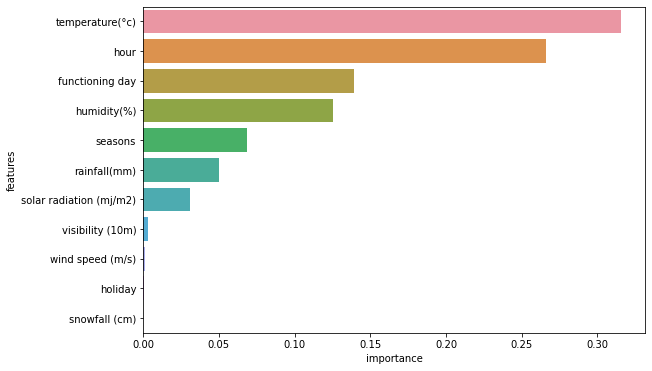

In [86]:
# plot feature importance
plt.figure(figsize=(9,6))

sns.barplot(x='feature_importance', y='feature', data=importance_df)

# setting labels
plt.xlabel("importance")
plt.ylabel("features")

plt.show()

# **XG Boost Regressor**

In [87]:
from xgboost import XGBRegressor

In [88]:
# creating an instance
xgb_model= XGBRegressor()

# fit model
xgb_model.fit(X_train, y_train)

[12:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [89]:
# Making predictions on train and test data
train_pred_xgb= xgb_model.predict(X_train)
test_pred_xgb= xgb_model.predict(X_test)

In [90]:
# Model score
xgb_model.score(X_train,y_train)

0.8883751493951902

### **Evaluation Metrics**

In [91]:
evaluation_metrics(train_pred_xgb,test_pred_xgb)

Evaluation metrics for train data
MSE : 17.36352548883358
RMSE : 4.166956381921172
MAE : 3.0077073243947487
 
R2 : 0.8883751493951902
Adjusted R2 :  0.887905778846011
--------------------------------------------------
Evaluation metrics for test data
MSE : 19.716160616682025
RMSE : 4.440288348371311
MAE : 3.2008525406955584
 
R2 : 0.8716379796595779
Adjusted R2 :  0.8710982311031006


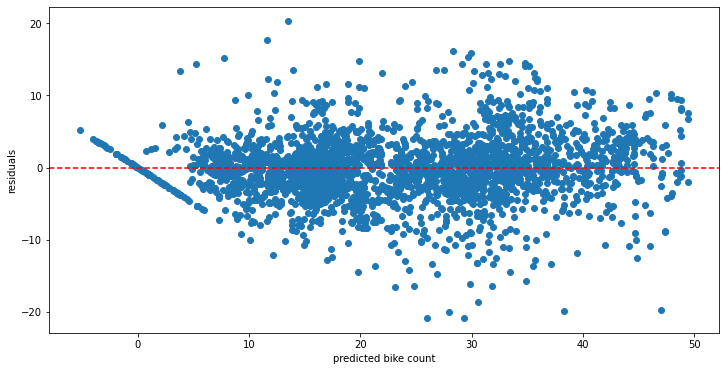

In [92]:
# Heteroscadacity
plt.figure(figsize=(12,6))
plt.style.use('default')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_xgb, y_test- test_pred_xgb)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

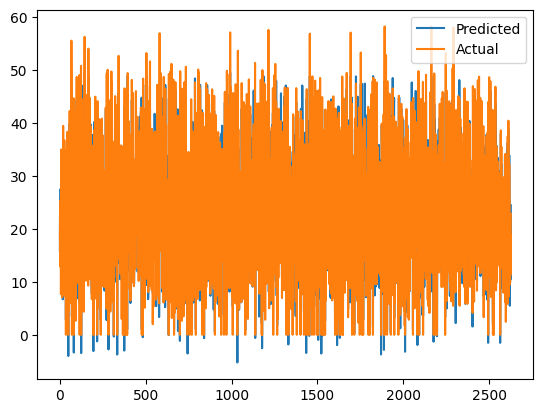

In [95]:
# plt.figure(figsize=(15,5))
plt.plot(np.array(test_pred_xgb))
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importances**

In [96]:
xgb_model.feature_importances_

array([0.08564787, 0.15955584, 0.09502066, 0.00266724, 0.00424582,
       0.06182754, 0.10346007, 0.00734474, 0.14745612, 0.0133808 ,
       0.31939337], dtype=float32)

In [97]:
# Get numerical feature importances
importances = list(xgb_model.feature_importances_)

# Dictionary with variable and importance
feature_importances= {'feature':list(X.columns), 'feature_importance':importances}

importance_df= pd.DataFrame(feature_importances)
importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)
importance_df

,feature,feature_importance
10,functioning day,0.319393
1,temperature(°c),0.159556
8,seasons,0.147456
6,rainfall(mm),0.103460
2,humidity(%),0.095021
0,hour,0.085648
5,solar radiation (mj/m2),0.061828
9,holiday,0.013381
7,snowfall (cm),0.007345
4,visibility (10m),0.004246


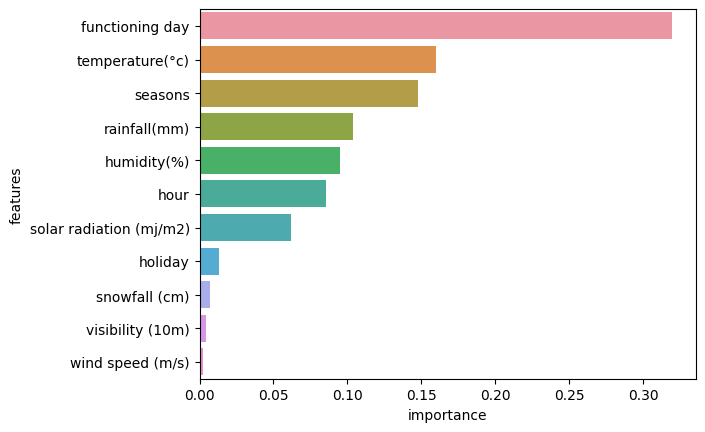

In [98]:
# Set the style
# plt.style.use('fivethirtyeight')
sns.barplot(x='feature_importance', y='feature', data=importance_df)

# setting labels
plt.xlabel("importance")
plt.ylabel("features")

plt.show()

# **XG Boost Regressor with GridSearchCV**

In [99]:
param_dict_xgb= {'learning_rate': [0.05, 0.07, 0.1],
             'max_depth': [3,5,7],
             'n_estimators': [50,100,150],
             'min_child_weight': [3, 5],
             'colsample_bytree': [0.5,0.7],
             'subsample': [0.5,0.7]
}

In [100]:
# Creating an instance 
xgb_model = XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,
                       param_grid = param_dict_xgb,
                       cv = 5, verbose=2)

xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[12:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.5; total time=   0.3s
[12:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.5; total time=   0.6s
[12:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.5; total time=   0.3s
[12:51:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytr

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.05, 0.07, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [3, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.5, 0.7]},
             verbose=2)

In [101]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 150,
 'subsample': 0.7}

In [102]:
xgb_grid.best_score_

0.9002976895101504

In [103]:
xgb_optimal_model= xgb_grid.best_estimator_

In [104]:
# Making predictions on train and test data
train_pred_xgrid= xgb_optimal_model.predict(X_train)
test_pred_xgrid= xgb_optimal_model.predict(X_test)

### **Evaluation Metrics**

In [105]:
evaluation_metrics(train_pred_xgrid,test_pred_xgrid)

Evaluation metrics for train data
MSE : 6.602146153898537
RMSE : 2.5694641764186046
MAE : 1.804132232194727
 
R2 : 0.9575568003989753
Adjusted R2 :  0.957378331287503
--------------------------------------------------
Evaluation metrics for test data
MSE : 15.728977459750388
RMSE : 3.965977491079644
MAE : 2.734113314633321
 
R2 : 0.8975965268352387
Adjusted R2 :  0.8971659311911973


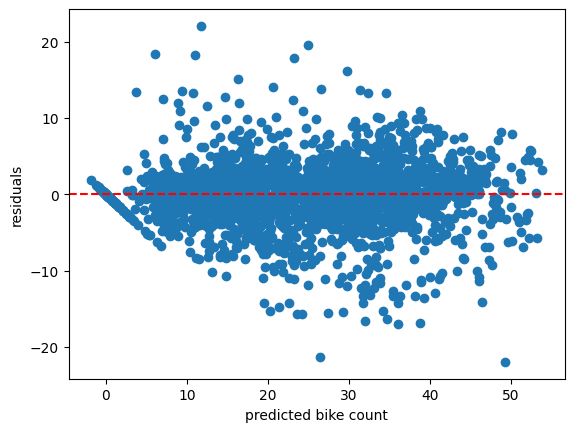

In [107]:
# Heteroscadacity
# plt.figure(figsize=(12,6))
plt.style.use('default')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.scatter(test_pred_xgrid, y_test- test_pred_xgrid)
plt.xlabel('predicted bike count')
plt.ylabel('residuals');

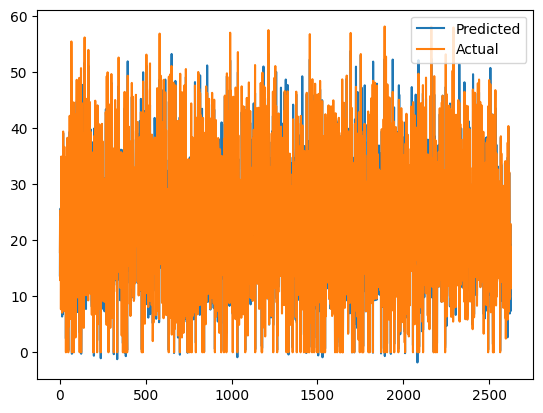

In [108]:
# plt.figure(figsize=(15,5))
plt.plot(np.array(test_pred_xgrid))
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

### **Feature Importances**

In [109]:
xgb_optimal_model.feature_importances_

array([0.08087585, 0.07325857, 0.03214004, 0.00681393, 0.00820561,
       0.02784801, 0.09397045, 0.02688522, 0.09462343, 0.01392818,
       0.54145074], dtype=float32)

In [110]:
# Get numerical feature importances
importances = list(xgb_optimal_model.feature_importances_)

# Dictionary with variable and importance
feature_importances= {'feature':list(X.columns), 'feature_importance':importances}

importance_df= pd.DataFrame(feature_importances)
importance_df.sort_values(by='feature_importance', ascending=False, inplace=True)
importance_df

,feature,feature_importance
10,functioning day,0.541451
8,seasons,0.094623
6,rainfall(mm),0.093970
0,hour,0.080876
1,temperature(°c),0.073259
2,humidity(%),0.032140
5,solar radiation (mj/m2),0.027848
7,snowfall (cm),0.026885
9,holiday,0.013928
4,visibility (10m),0.008206


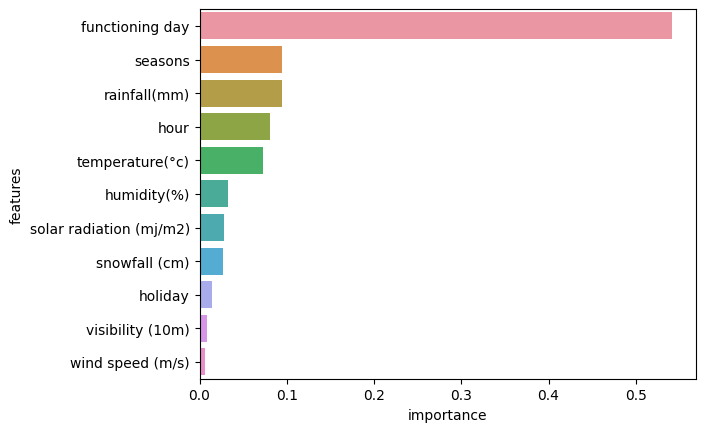

In [111]:
# Set the style
# # plt.figure(figsize=(9,6))

sns.barplot(x='feature_importance', y='feature', data=importance_df)

# setting labels
plt.xlabel("importance")
plt.ylabel("features")

plt.show()